In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50

import os
import shutil
import random

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [4]:
# 데이터 경로
base_dir = "C:\\Users\\user\\Downloads\\data\\pre_image"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# train, test 분리 비율
split_ratio = 0.2  # 8:2

clusters = ['0', '1', '2', '3']

for cluster in clusters:
    cluster_dir = os.path.join(base_dir, cluster)
    images = os.listdir(cluster_dir)
    random.shuffle(images)  # 이미지 목록 랜덤하게 섞기

    # 분리할 이미지 개수 계산
    train_count = int(len(images) * split_ratio)
    
    # 이미지 분리
    train_images = images[:train_count]
    test_images = images[train_count:]

    # train 폴더에 이미지 옮기기
    for image in train_images:
        src = os.path.join(cluster_dir, image)
        dst = os.path.join(train_dir, cluster, image)
        os.makedirs(os.path.join(train_dir, cluster), exist_ok=True)
        shutil.move(src, dst)

    # test 폴더에 이미지 옮기기
    for image in test_images:
        src = os.path.join(cluster_dir, image)
        dst = os.path.join(test_dir, cluster, image)
        os.makedirs(os.path.join(test_dir, cluster), exist_ok=True)
        shutil.move(src, dst)


In [6]:
# 데이터 경로
base_dir = "C:\\Users\\user\\Downloads\\data\\pre_image"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# 데이터 전처리
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 검증 데이터 분리 설정 추가
test_datagen = ImageDataGenerator(rescale=1./255)  # test 데이터 전처리

def build_model(model_name, input_size, num_classes=4):
    if model_name == 'basic_cnn':
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(input_size, input_size, 3)),
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(256, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
    elif model_name == 'vgg16':
        base_model = VGG16(input_shape=(input_size, input_size, 3), include_top=False, weights='imagenet')
        base_model.trainable = False
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
    elif model_name == 'resnet50':
        base_model = ResNet50(input_shape=(input_size, input_size, 3), include_top=False, weights='imagenet')
        base_model.trainable = False
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
    
    # 모델 컴파일
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델, target size, batch size, epochs 설정
model_name = 'vgg16'
target_size = 120
batch_size = 128
epochs = 20

# Early stopping 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3)

print(f"Training {model_name} with size {target_size}")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 학습 데이터 부분만 가져오기
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 검증 데이터 부분만 가져오기
)

model = build_model(model_name, target_size)
model.summary()  # 모델 구조 출력

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[TqdmCallback(verbose=1), early_stop],
    verbose=0
)

Training vgg16 with size 120
Found 9905 images belonging to 4 classes.
Found 2474 images belonging to 4 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               2359808   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 17076548 (65.14 MB)
Trainable params: 2361860 (9.01 MB)
Non

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [7]:
# test 데이터 로드
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # 테스트 시에는 데이터를 섞을 필요가 없습니다.
)

# 모델 성능 평가
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Found 3097 images belonging to 4 classes.
24/24 [==============================] - 191s 8s/step - loss: 0.6115 - accuracy: 0.7422
Test Loss: 0.6115
Test Accuracy: 0.7422


In [ ]:
clusters = os.listdir(test_dir)

for cluster in clusters:
    cluster_dir = os.path.join(test_dir, cluster)
    
    # 해당 클러스터의 테스트 데이터 로드
    cluster_test_generator = test_datagen.flow_from_directory(
        cluster_dir,
        target_size=(target_size, target_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # 모델 성능 평가
    loss, accuracy = model.evaluate(cluster_test_generator, steps=cluster_test_generator.samples // batch_size)
    print(f"Cluster: {cluster}")
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("------------------------------")


1/1 [==============================] - 0s 56ms/step


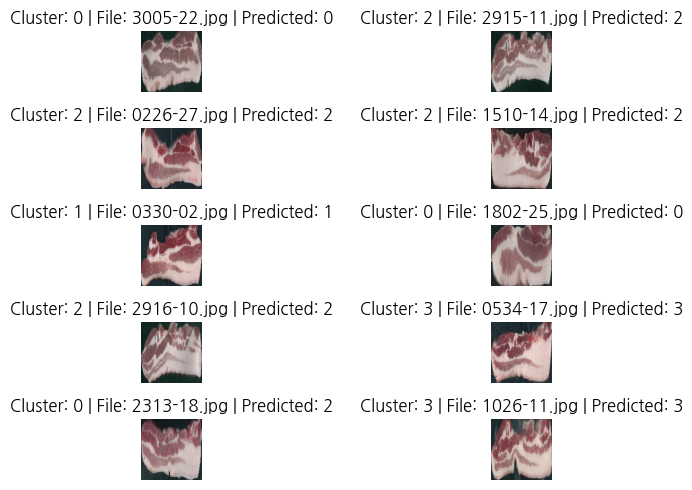

In [30]:
# 임의의 5장의 이미지를 선택
test_images = []
for cluster in clusters:
    test_images.extend([os.path.join(test_dir, cluster, img) for img in os.listdir(os.path.join(test_dir, cluster))])
selected_images = np.random.choice(test_images, 10)

# 이미지 불러오기, 전처리 및 예측
predictions = []
for img_path in selected_images:
    img = image.load_img(img_path, target_size=(target_size, target_size))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    
    img_preprocessed = test_datagen.standardize(img_batch)
    pred = model.predict(img_preprocessed)
    predictions.append(np.argmax(pred))

# 시각화
fig, axes = plt.subplots(5, 2, figsize=(10, 5))  # 3행 2열의 subplot 생성

for ax, img_path, pred in zip(axes.ravel(), selected_images, predictions):
    img = image.load_img(img_path, target_size=(target_size, target_size))
    ax.imshow(img)
    
    # 파일 이름과 클러스터 정보를 함께 표시
    file_name = os.path.basename(img_path)
    cluster_name = os.path.basename(os.path.dirname(img_path))  # 이미지가 위치한 폴더(클러스터) 이름 추출
    ax.set_title(f"Cluster: {cluster_name} | File: {file_name} | Predicted: {pred}")
    ax.axis('off')

# 불필요한 subplot 제거
axes[2, 1].axis('off')
plt.tight_layout()
plt.show()


In [31]:
# 모델, target size, batch size, epochs 설정
model_name = 'basic_cnn'
target_size = 150

print(f"Training {model_name} with size {target_size}")

# 데이터 생성기 설정
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 학습 데이터 부분만 가져오기
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 검증 데이터 부분만 가져오기
)

# 'basic_cnn' 모델 구성
model = build_model(model_name, target_size)
model.summary()  # 모델 구조 출력

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[TqdmCallback(verbose=1), early_stop],
    verbose=0
)

Training basic_cnn with size 150
Found 9905 images belonging to 4 classes.
Found 2474 images belonging to 4 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
   

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
model_names = ['basic_cnn', 'vgg16']
input_sizes = [120, 150]

models = {}  # 각 모델의 결과를 저장할 딕셔너리

for m_name in model_names:
    for size in input_sizes:
        print(f"Training {m_name} with size {size}")
        
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(size, size),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training'
        )
        
        validation_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(size, size),
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation'
        )
        
        model = build_model(m_name, size)
        model.summary()
        
        # 모델 학습
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            epochs=epochs,
            callbacks=[TqdmCallback(verbose=1), early_stop],
            verbose=0
        )
        
        models[f"{m_name}_{size}"] = model  # 학습된 모델 저장



In [ ]:
# 각 모델에 대한 테스트 성능 평가
for model_key in models.keys():
    print(f"Evaluating {model_key} ...")
    
    # 클러스터별 성능 평가
    for cluster in clusters:
        cluster_dir = os.path.join(test_dir, cluster)
        
        # 해당 클러스터의 테스트 데이터 로드
        cluster_test_generator = test_datagen.flow_from_directory(
            cluster_dir,
            target_size=(size, size),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        # 모델 성능 평가
        loss, accuracy = models[model_key].evaluate(cluster_test_generator, steps=cluster_test_generator.samples // batch_size)
        print(f"Cluster: {cluster}")
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print("------------------------------")
    
    # 전체 테스트 데이터에 대한 성능 평가
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(size, size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    loss, accuracy = models[model_key].evaluate(test_generator, steps=test_generator.samples // batch_size)
    print(f"Model: {model_key}")
    print(f"Overall Test Loss: {loss:.4f}")
    print(f"Overall Test Accuracy: {accuracy:.4f}")
    print("=================================")
